In [2]:
import PIL.Image as Image
import cv2 as cv
import numpy as np

(450, 800)


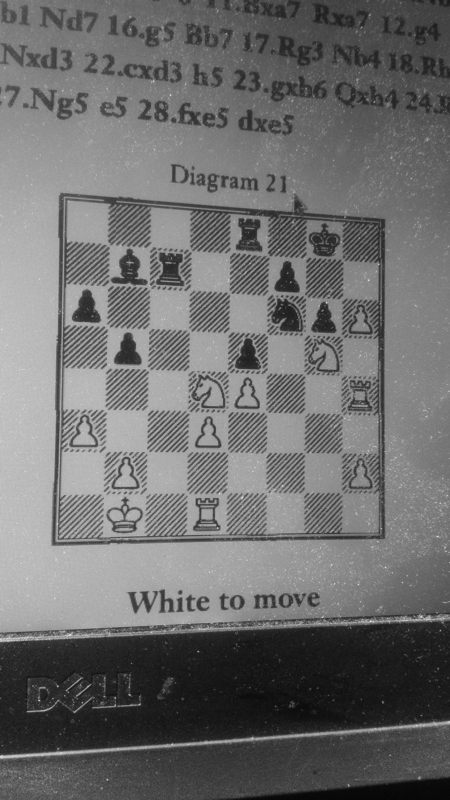

In [3]:
#
# Original image
#
image = Image.open('data/example/ex004.jpg').convert('L')
image.thumbnail([800, 800])
print(image.size)
image

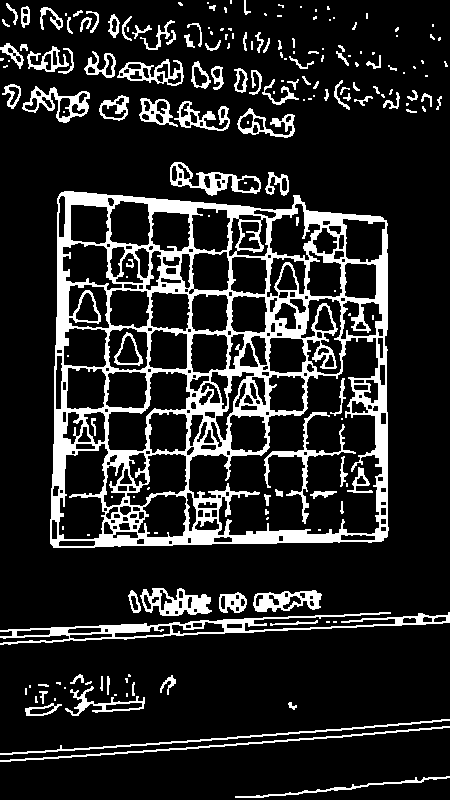

In [4]:
#
# Edge detection
#
x = np.array(image)

def method1(x):
    x = cv.GaussianBlur(x, (7, 7), 7)
    x = cv.Canny(x, 50, 50)
    x = cv.dilate(x, np.ones([4, 4], dtype=np.uint8))
    x = cv.erode(x, np.ones([3, 3], dtype=np.uint8))
    return x

def method2(x):
    x = cv.GaussianBlur(x, (7, 7), 7)
    x = cv.adaptiveThreshold(x, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    x = cv.bitwise_not(x)
    x = cv.dilate(x, np.ones([4, 4], dtype=np.uint8))
    x = cv.erode(x, np.ones([4, 4], dtype=np.uint8))
    return x

x = method1(x)

Image.fromarray(x)

In [5]:
#
# Find contour
#
contours = cv.findContours(x, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
contours = sorted(contours, key = cv.contourArea, reverse = True)
len(contours)

471

In [6]:
np.array([len(c) for c in contours])[:16]

array([164, 524, 252, 132, 118, 105,  96,  95,  58, 118,  53,  71,  66,
       240,  53,  67])

In [7]:
np.array([cv.contourArea(c) for c in contours])[:16]

array([112951.5,  20419.5,   3667. ,   3534. ,   2909. ,   1773. ,
         1734.5,   1683. ,   1600.5,   1596.5,   1545.5,   1524. ,
         1504.5,   1499.5,   1486. ,   1464.5])

In [8]:
#
# Choose largest contour as board quadraliteral
#
contour = contours[0]
contour = cv.approxPolyDP(contour, cv.arcLength(contour, True) / 20, True)
contour

array([[[ 61, 192]],

       [[ 53, 547]],

       [[383, 540]],

       [[386, 220]]], dtype=int32)

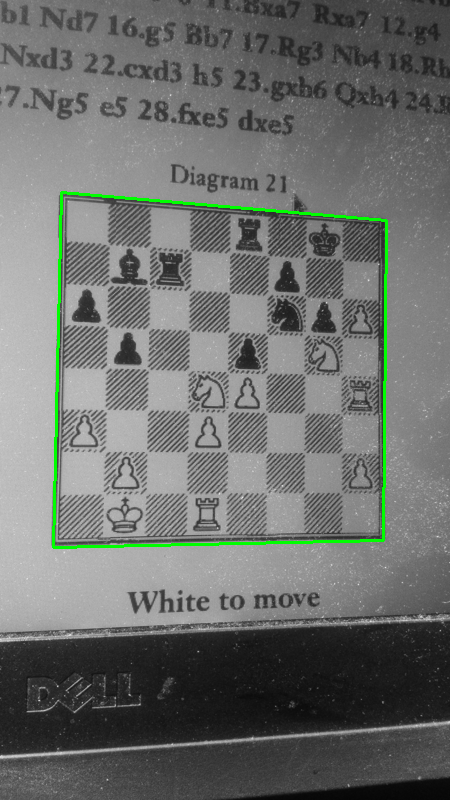

In [9]:
y = np.array(image.convert('RGB')).copy()
cv.drawContours(y, [contour], -1, (0,255,0), 2)
Image.fromarray(y)

In [10]:
#
# order quadraliteral vertices by counter clock wise from top left
#
def order_points(pts):
    if np.linalg.det(np.array([pts[1] - pts[0], pts[2] - pts[0]])) < 0:
        pts = np.flip(pts, axis=0)
    top_left = np.argmin(pts[:, 0] + pts[:, 1])
    pts = np.roll(pts, -top_left, axis=0)
    return pts

quad = order_points(contour.squeeze())

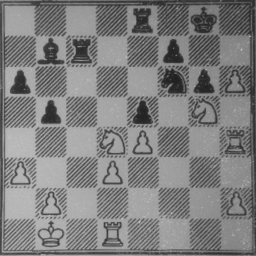

In [11]:
#
# Perspective transform quadraliteral to square
#

w = h = 256
square = np.array([[0, 0], [h, 0], [h, w], [0, w]])

transform = cv.getPerspectiveTransform(quad.astype(np.float32), square.astype(np.float32))
z = cv.warpPerspective(np.array(image), transform, (h, w))
Image.fromarray(z)

In [12]:
Image.fromarray(z).save('data/example/ex004--board.png')